In [1]:
import numpy as np
import re, string
import matplotlib.pyplot as plt
import random as rd
from math import sqrt
import operator
import re
import json
import skfuzzy as fuzz
from scipy import stats
import spacy
import fr_core_news_md
#load the small English model
nlp = fr_core_news_md.load()
import pandas as pd
#Global variables
#nltk.download('punkt')
#nltk.download()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option("display.max_rows", 600)
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial import distance

/home/luis/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/luis/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
def triangleFunction(points, xrange):
    values = {}
    for k, v in xrange:
        if v <= points['a']:
            values[k]=0
        elif (v >= points['a'] and v <= points['b']):
            values[k]=(v-points['a'])/(points['b'] - points['a'])
        elif v >= points['b'] and v <= points['c']:
            values[k]=(points['c']-v)/(points['c'] - points['b'])
        elif v >= points['c']:
            values[k]=0
    return values
pass

def linearFunction(points, xrange):
    values = {}    
    for k, v in xrange:
        if v<points['a']:
            values[k]=0
        elif (v>=points['a'] and v<points['b']):
            values[k]=(v-points['a'])/(points['b'] - points['a'])
        elif v>=points['b']:
            values[k]=1
    return values
pass

In [3]:
def getAxisValues(axis,stepSize):
    return np.arange(axis['xmin'], axis['xmax'], stepSize)
pass

In [233]:
def getTokens(_sentences, opc, isArray):
    tokens=[]
    if isArray:
        for sentence in _sentences:
            words=nlp(sentence) #filtre_stopfr(word_tokenize(sentence, language="french"))
            for word in words:
                if opc==1 and len(word.text) > 1 and word.lemma_ not in tokens and word.is_stop is False:
                    tokens.append(word.lemma_)
                elif opc==2 and len(word.text) > 1 and word.lower_ not in tokens and word.is_stop is False:
                    tokens.append(word.lower_)
                elif opc==3 and len(word.text) > 1 and word.is_stop is False:
                    tokens.append(word.lower_)
    else:
        words=nlp(_sentences)
        for word in words:
            if opc and len(word.text) > 1 and word.lemma_ not in tokens and word.is_stop is False:
                tokens.append(word.lemma_)
            elif not opc and len(word.lower_) > 1 and word.lower_ not in tokens and word.is_stop is False:
                tokens.append(word.lower_)
    return tokens

In [5]:
def normalize(arr,t_min,t_max):
    norm_arr = arr
    #norm_arr_2 = []
    v_max = v_min = arr[0][0]
    for v in arr: 
        if(v_max < max(v)): v_max = max(v) 
        if(v_min > min(v)): v_min = min(v)
    diff_arr = v_max - v_min
    diff = t_max - t_min
    
    for l in range(len(arr)):
        for i in range(len(arr[l])):
            temp = (((arr[l][i] - v_min)*diff)/diff_arr) + t_min
            norm_arr[l][i]=temp
            #norm_arr_2.append(temp)
        #norm_arr.append(norm_arr_2)
    return norm_arr

In [223]:
def getMatrix(_tokens, _rows, lemmatize):
    matrix = np.zeros((len(_rows),len(_tokens)))
    f = 0
    for l in _rows:
        c = 0
        words = getTokens(l,lemmatize, False)
        for token in _tokens:
            if token in words : matrix[f][c]=1
            c+=1
        f+=1
    matrixT = matrix.transpose()
    producto_M = matrix.dot(matrixT)
    MatrixE = producto_M.dot(producto_M)
    return normalize(MatrixE,0,1)
    #return MatrixE

In [224]:
def getMatrixTfidf(_tokens, _rows, lemmatize):
    matrix = np.zeros((len(_rows),len(_tokens)))
    f = 0
    for l in _rows:
        c = 0
        words = getTokens(l,lemmatize, False)
        for token in _tokens:
            if token in words :
                try:
                    matrix[f][c]=tfidf_df[token]['20081219_xinhuanet_fr_f090592976aaaf013cdc254f70319116']
                except: 
                    matrix[f][c]=0
            c+=1
        f+=1
    matrixT = matrix.transpose()
    producto_M = matrix.dot(matrixT)
    MatrixE = producto_M.dot(producto_M)
    return normalize(MatrixE,0,1)
    #return MatrixE

In [8]:
def textualEnergy(_MatrixCurrent, _curr_index):
    vSum=0
    for l in _MatrixCurrent:
        vSum+=sum(l)
    vAvg=vSum/len(_MatrixCurrent)
    if (sum(_MatrixCurrent[_curr_index]) > vAvg): return True
    else: return False

In [9]:
def getIndex(self_current_row):
    m_trie=sorted(self_current_row, reverse=1)
    for ite in m_trie:
        curr_index_list = np.where(self_current_row == ite)
        #print(self_current_row,ite,curr_index_list,'-----------')
        for curr_index in curr_index_list[0]:
            if MatrixCurrent[curr_index] is not self_current_row and curr_index not in list_used:
                if textualEnergy(MatrixCurrent,curr_index):
                    #print(curr_index, list(lemmas.keys())[curr_index])
                    return int(curr_index)

In [10]:
def cleanSentences(o_sentences):
    s_sentences={}
    contador=0
    for sentence in o_sentences:        
        if 0<len(sentence.split())<100: s_sentences[contador] = sentence
        contador+=1
    return s_sentences

In [11]:
def openCorpus(pathJason, idNews):
    pathCorpus = "/home/luis/Documents/french-docs/"
    #Reading Jason with all information about corpus
    with open(pathCorpus+pathJason, "r") as file:
        data = json.load(file)
    #Reading name's file of news
    articles=[]
    articles2=[]
    for key in data :
        articles.append(data[key]['document_path'])
        articles2.append(pathCorpus+data[key]['document_path'])
    #Reading the selected news
    news = open(pathCorpus+articles[idNews],'r').readlines()
    #Extracting paragraphs
    reg_str = "<p>(.*?)</p>"
    #news[1] ignoring the first element of the list, usually the title
    #[0] is to get directly the only element in list in str format
    filteredText = re.findall(reg_str, news[1])[0].replace('\\','')
    segmentedSent = nlp(filteredText)
    assert segmentedSent.has_annotation("SENT_START")
    vectorSent=[]
    for sent in segmentedSent.sents:
        vectorSent.append(sent.text)
    #Formatting into a dictionary of sentences
    return cleanSentences(vectorSent), calculateTfidf(articles2)

In [12]:
def calculateTfidf(_articles):
    text_titles = [Path(text).stem for text in _articles]
    tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words=stopwords.words('french'))
    tfidf_vector = tfidf_vectorizer.fit_transform(_articles)
    return pd.DataFrame(tfidf_vector.toarray(), index=text_titles, columns=tfidf_vectorizer.get_feature_names_out())
    

In [25]:
#Looking for news in position 0
lemma = 1
dictSentences, tfidf_df = openCorpus("french-docs.json", 0)
tokens =  getTokens(dictSentences.values(),lemma, True)
MatrixVocab = getMatrix(tokens, dictSentences.values(), lemma)

In [226]:
#Looking for news in position 0
lemma = 2
dictSentences, tfidf_df = openCorpus("french-docs.json", 0)
tokens =  getTokens(dictSentences.values(),lemma, True)
MatrixVocab = getMatrixTfidf(tokens, dictSentences.values(), lemma)

In [237]:
def setVector(_word, _vectorET, _vectorWords):
    vector = []
    for word in _vectorWords:
        if _word == word:
            vector.append(sum(_vectorET))
        else: vector.append(0)
    return vector

In [238]:
#matrix = np.zeros((len(tokens),len(dictSentences)))
vectorWords =  getTokens(dictSentences.values(),3, True)
matrix = []
for row in tokens:
    _row = []
    for sent, vectorET in zip(dictSentences.values(), MatrixVocab):
        if row in sent.lower():
            _row.append(setVector(row, vectorET, vectorWords))
        else:
            _row.append(np.zeros(len(vectorWords)))
    matrix.append(_row)

In [240]:
matrixT = np.transpose(matrix, (1, 0, 2))

In [307]:
producto_M = []
#matrix has the values of all the vocabulary, one word for each row -> x
for x in matrix:
#    print("X =", x, len(x))
    _row=[]
    #Serves to iterate the columns of transposed matrix
    for xT in range(len(matrixT[0])):
        #Recover the element of column xT in transposed matrix
        colElem=np.array(matrixT)[:,xT]
 #       print("Y = ", colElem)
        scalarP=0
        #x has the TE of all sentences, one sentence for each column -> y
        #yt has the TE values of each sentence recovered for each word in columns from MatrixT
        for y, yT in zip(x, colElem):  
            #Calculate cosinus similarity
            scalarP+= 1 - distance.euclidean(y, yT)
        _row.append(scalarP/len(colElem))
    producto_M.append(_row)      

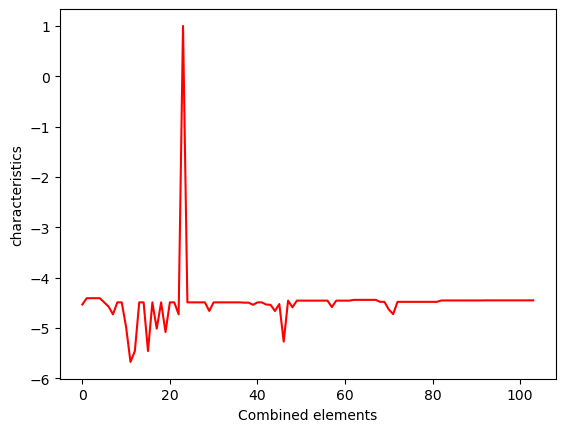

In [311]:
i=23
plt.plot(producto_M[i],'r')
plt.ylabel("characteristics")
plt.xlabel("Combined elements")
plt.show()

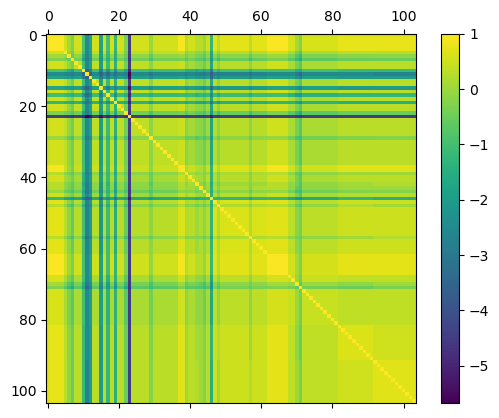

In [309]:
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(producto_M, interpolation ='nearest')
figure.colorbar(caxes)
plt.show()

In [187]:
dictSentences

{0: 'HARARE, 19 décembre (Xinhua)',
 1: '--',
 2: "Le directeur régional pour l'Afrique de l'Organisation mondiale de la santé (OMS), le Dr Luis Gomes Sambo, se trouve au Zimbabwe pour effectuer une visite de routine et évaluer l'éruption du choléra qui avait fait, selon le dernier bilan publié jeudi, 1.111 morts et 20.581 infectés, a rapporté vendredi le quotidien The Herald.",
 3: 'Le Dr Sambo est arrivé mercredi à Harare.',
 4: "Selon l'OMS, la visite du Dr Sambo est liée à l'éruption de choléra au Zimbabwe et à ses implications régionales, étant donné que l'Afrique du Sud et le Botswana ont signalé des cas de choléra.",
 5: "Au début de ce mois, les autorités sud-africaines de la santé ont fait savoir que leur pays avaient enregistré plus de 400 cas de choléra et neuf morts liées à l'épidémie dans les régions limitrophes avec le Zimbabwe, alors que le Botswana a également confirmé trois cas, tous des Zimbabwéens.",
 6: 'Trois autres cas ont été également signalés au poste frontière

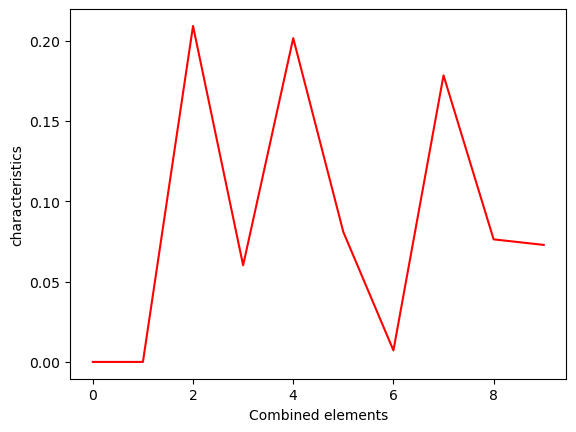

In [23]:
i=3
plt.plot(MatrixVocab[i],'r')
plt.ylabel("characteristics")
plt.xlabel("Combined elements")
plt.show()

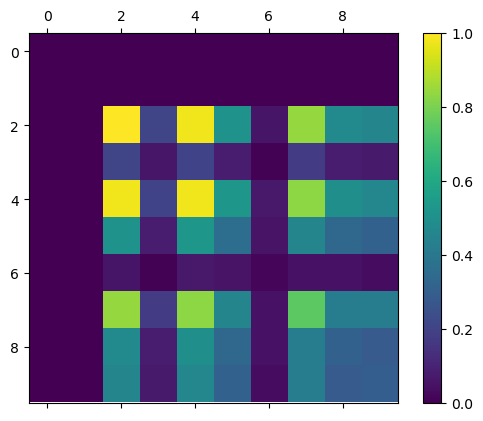

In [18]:
figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(MatrixVocab, interpolation ='nearest')
figure.colorbar(caxes)
plt.show()

In [17]:
fuzzyVector = []
for sent in MatrixVocab:
    fuzzyVector.append(sum(sent))
fuzzyVector = dict(zip(dictSentences.keys(), fuzzyVector))
# Setting a domain field.
vMin = min(fuzzyVector.values())
vMax = max(fuzzyVector.values())
vMean = np.median(list(fuzzyVector.values()))
xaxis = { 'xmin':vMin, 'xmax':vMax}

# Creating the values for the domain of all our membership functions.
xrange = getAxisValues(xaxis, 0.5)

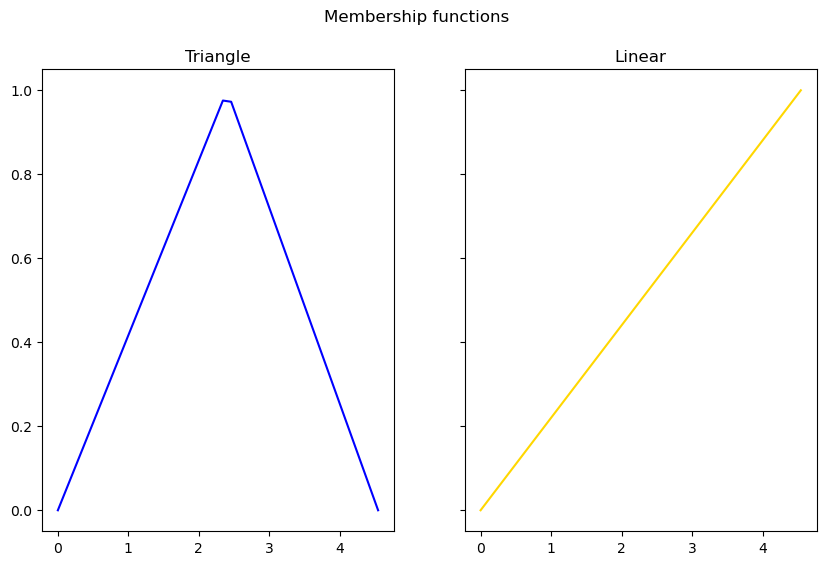

In [18]:
sortedValues = dict(sorted(fuzzyVector.items(), key=lambda item: item[1]))

linearPoints = {'a':vMin,  'b': vMax}
linearFunctionV = linearFunction(linearPoints, sortedValues.items())

trianglePoints = {'a':vMin,  'b': vMean , 'c': vMax}
triangleFunctionV = triangleFunction(trianglePoints, sortedValues.items())

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
axs[0].plot(sortedValues.values(), triangleFunctionV.values(), 'blue' )
axs[1].plot(sortedValues.values(), linearFunctionV.values(), 'gold' )
axs[0].title.set_text('Triangle')
axs[1].title.set_text('Linear')

# Setting the main title
plt.suptitle('Membership functions')

# Show us what you got!
plt.show()

In [42]:
#list to store the tokens and pos tags 
sentence = nlp(dictSentences.get(max(linearFunctionV, key=linearFunctionV.get)))
p=[]
print("keys words = ")
for word in sentence:
    if word.pos_ in ['NOUN','PROPN','VERB'] and not word.is_stop:
        child = ""
        if len(list(word.children)) > 0: child = list(word.children)[0]
        if len(p) > 0:
            if p[-1] is not child : p.append(child)
            p.append(word.text)
        else: 
            p.append(child)
            p.append(word.text)
        print(word.head.text, word.text, [child for child in word.children])
print(p)

keys words = 
liée OMS [Selon, l']
liée visite [la, Dr]
visite Dr [du, Sambo]
Dr Sambo []
liée liée [OMS, ,, visite, est, éruption, ,, étant, .]
liée éruption [à, l', choléra, implications]
éruption choléra [de, Zimbabwe]
choléra Zimbabwe [au]
éruption implications [et, à, ses, régionales]
étant donné []
signalé Afrique [l', Sud, Botswana]
Afrique Sud [du]
Afrique Botswana [et, le]
étant signalé [que, Afrique, ont, cas]
signalé cas [des, choléra]
cas choléra [de]
[Selon, 'OMS', la, 'visite', du, 'Dr', '', 'Sambo', OMS, 'liée', à, 'éruption', de, 'choléra', au, 'Zimbabwe', et, 'implications', '', 'donné', l', 'Afrique', du, 'Sud', et, 'Botswana', que, 'signalé', des, 'cas', de, 'choléra']


In [40]:
#list to store the tokens and pos tags 
sentence = nlp(dictSentences.get(max(triangleFunctionV, key=triangleFunctionV.get)))
p=[]
print("keys words = ")
for word in sentence:
    if word.pos_ in ['NOUN','PROPN','VERB'] and not word.is_stop:
        child = ""
        if len(list(word.children)) > 0: child = list(word.children)[0]
        if len(p) > 0:
            if p[-1] is not child : p.append(child)
            p.append(word.text)
        else: 
            p.append(child)
            p.append(word.text)
        print(word.head.text, word.text, [child for child in word.children])
print(p)

keys words = 
travaille agence [L', ONU]
agence ONU [de, l']
travaille travaille [agence, actuellement, gouvernement, établir, .]
travaille gouvernement [avec, le, zimbabwéen, partenaires]
gouvernement partenaires [et, d', autres]
travaille établir [pour, centre, afin]
établir centre [un, contrôle]
centre contrôle [de, commandement]
contrôle commandement [et, de, choléra]
commandement choléra [du]
afin favoriser [de, réponse]
favoriser réponse [une, coordonnée, épidémie]
réponse coordonnée []
réponse épidémie [à, l']
[L', 'agence', de, 'ONU', agence, 'travaille', avec, 'gouvernement', et, 'partenaires', pour, 'établir', un, 'centre', de, 'contrôle', et, 'commandement', du, 'choléra', de, 'favoriser', une, 'réponse', '', 'coordonnée', à, 'épidémie']


In [41]:
sentence

L'agence de l'ONU travaille actuellement avec le gouvernement zimbabwéen et d'autres partenaires pour établir un centre de contrôle et de commandement du choléra afin de favoriser une réponse coordonnée à l'épidémie.